In [ ]:
### Authenticate with Google Cloud Platform to run BigQuery queries
from google.colab import auth
auth.authenticate_user()

**bold text**# Description

SQL query that returns metrics on fees earned by MetaMask from their swap service during the month of August 2021. only interested in fees paid in ETH and WETH.

- Sum of fees per day
- Average fee per transaction per day
- Cumulative (rolling sum) sum of fees per day



In [ ]:
### VERSION 1

In [ ]:
%%bigquery --project ethereum-380219 --use_bqstorage_api resulting_df


WITH metamask_metrics_eth AS (
SELECT 
  DATE(tt.block_timestamp) AS day,
  tt.value AS eth_fees -- getting Metamask fees
FROM `bigquery-public-data.crypto_ethereum.transactions` AS t
JOIN `bigquery-public-data.crypto_ethereum.token_transfers` AS tt 
  ON t.hash = tt.transaction_hash
JOIN  `bigquery-public-data.crypto_ethereum.traces` AS traces
  ON t.hash = traces.transaction_hash
WHERE 
  UPPER(t.TO_ADDRESS) = '0X881D40237659C251811CEC9C364EF91DC08D300C' -- Metamask address router
  AND UPPER(tt.to_address) = '0X11EDEDEBF63BEF0EA2D2D071BDF88F71543EC6FB' -- Metamask swap fee address
  # AND tok.symbol = 'ETH' -- filtering out only WETH & ETH
  AND t.block_timestamp >= TIMESTAMP('2021-08-01')
  AND t.block_timestamp < TIMESTAMP('2021-09-01')
# GROUP BY day
ORDER BY day ASC
# remove the limit if needed
LIMIT 5
),

metamask_metrics_weth AS (
SELECT 
  DATE(tt.block_timestamp) AS day,
  tt.value AS weth_fees -- getting Metamask fees
FROM `bigquery-public-data.crypto_ethereum.transactions` AS t
JOIN `bigquery-public-data.crypto_ethereum.token_transfers` AS tt 
  ON t.hash = tt.transaction_hash
WHERE 
  UPPER(t.TO_ADDRESS) = '0X881D40237659C251811CEC9C364EF91DC08D300C' -- Metamask address router
  AND UPPER(tt.to_address) = '0X11EDEDEBF63BEF0EA2D2D071BDF88F71543EC6FB' -- Metamask swap fee address
  AND tt.token_address = '0XC02AAA39B223FE8D0A0E5C4F27EAD9083C756CC2'-- WETH filter
  AND t.block_timestamp >= TIMESTAMP('2021-08-01')
  AND t.block_timestamp < TIMESTAMP('2021-09-01')
# GROUP BY day
ORDER BY day ASC
# remove the limit if needed
LIMIT 5
),

SELECT 
  DATE(tt.block_timestamp) AS day,
  SUM(CAST(tt.value AS FLOAT64)) / 1e18 AS token_fees, -- getting Metamask fees
  AVG(CAST(tt.value AS FLOAT64)) / 1e18 AS avg_fees,
  SUM(eth_fees) OVER (ORDER BY day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_fees
from (
  select * from metamask_metrics_eth 
  UNION ALL 
  select * from  metamask_metrics_weth)
group by 1
ORDER BY day ASC;



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
resulting_df

,day,eth_fees,avg_fees,total_fees
0,2021-08-01,0.844772,0.010429,0.844772
1,2021-08-02,1.880119,0.022119,2.724891
2,2021-08-03,1.366298,0.021020,4.091189
3,2021-08-04,1.083879,0.015939,5.175069
4,2021-08-05,0.503954,0.010079,5.679022


<AxesSubplot:xlabel='day'>

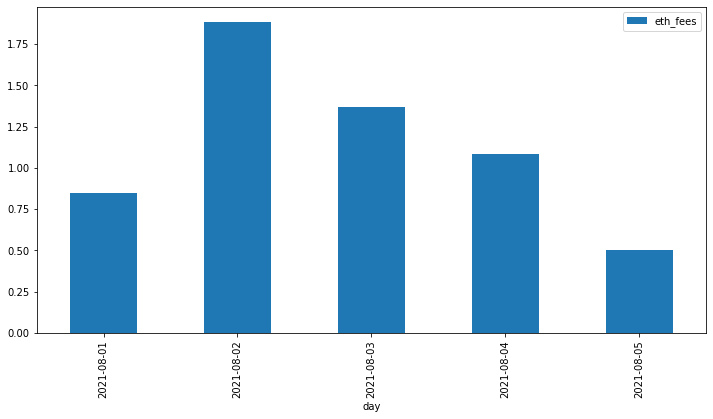

In [ ]:
resulting_df.plot(
    y='eth_fees',
    x='day',
    kind='bar',
    figsize=(12,6)
)